In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [7]:
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,A,B,A,A,B,D,A,E,C,...,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,2,B,A,A,A,B,B,A,E,A,...,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,3,A,A,A,C,B,D,A,B,C,...,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,4,A,A,A,C,B,D,A,E,G,...,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,6,A,B,A,A,B,B,A,E,C,...,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [8]:
train.drop(columns = ['id'], inplace=True)
test.drop(columns = ['id'], inplace=True)

In [9]:
train = train[(train['target'] > 4) & (train['target'] < 10)]

In [10]:
train.shape

(299900, 25)

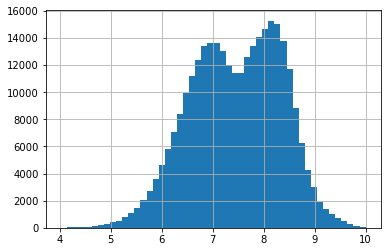

In [11]:
train['target'].hist(bins=50)

In [12]:
class TabularDataset(Dataset):
    def __init__(self, data, cat_cols=None, output_col=None):
        """
        Characterizes a Dataset for PyTorch
        Parameters
        ----------
        data: pandas data frame
        The data frame object for the input data. It must
        contain all the continuous, categorical and the
        output columns to be used.
        cat_cols: List of strings
        The names of the categorical columns in the data.
        These columns will be passed through the embedding
        layers in the model. These columns must be
        label encoded beforehand. 
        output_col: string
        The name of the output variable column in the data
        provided.
        """

        self.n = data.shape[0]

        if output_col:
            self.y = data[output_col].astype(np.float32).values.reshape(-1, 1)
        else:
            self.y = np.zeros((self.n, 1))

        self.cat_cols = cat_cols if cat_cols else []
        self.cont_cols = [
            col for col in data.columns if col not in self.cat_cols + [output_col]
        ]

        if self.cont_cols:
            self.cont_X = data[self.cont_cols].astype(np.float32).values
        else:
            self.cont_X = np.zeros((self.n, 1))

        if self.cat_cols:
            self.cat_X = data[cat_cols].astype(np.int64).values
        else:
            self.cat_X = np.zeros((self.n, 1))

    def __len__(self):
        """
        Denotes the total number of samples.
        """
        return self.n

    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]


In [13]:
class FeedForwardNN(nn.Module):
    def __init__(
        self,
        emb_dims,
        no_of_cont,
        lin_layer_sizes,
        output_size,
        emb_dropout,
        lin_layer_dropouts,
    ):

        """
        Parameters
        ----------
        emb_dims: List of two element tuples
        This list will contain a two element tuple for each
        categorical feature. The first element of a tuple will
        denote the number of unique values of the categorical
        feature. The second element will denote the embedding
        dimension to be used for that feature.
        
        no_of_cont: Integer
        The number of continuous features in the data.
        
        lin_layer_sizes: List of integers.
        The size of each linear layer. The length will be equal
        to the total number
        of linear layers in the network.
        
        output_size: Integer
        The size of the final output.
        
        emb_dropout: Float
        The dropout to be used after the embedding layers.
        
        lin_layer_dropouts: List of floats
        The dropouts to be used after each linear layer.
        """

        super().__init__()

        # Embedding layers
        self.emb_layers = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims])

        no_of_embs = sum([y for x, y in emb_dims])
        self.no_of_embs = no_of_embs
        self.no_of_cont = no_of_cont

        # Linear Layers
        first_lin_layer = nn.Linear(
            self.no_of_embs + self.no_of_cont, lin_layer_sizes[0]
        )

        self.lin_layers = nn.ModuleList(
            [first_lin_layer]
            + [
                nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
                for i in range(len(lin_layer_sizes) - 1)
            ]
        )

        for lin_layer in self.lin_layers:
            nn.init.kaiming_normal_(lin_layer.weight.data)

        # Output Layer
        self.output_layer = nn.Linear(lin_layer_sizes[-1], output_size)
        nn.init.kaiming_normal_(self.output_layer.weight.data)

        # Batch Norm Layers
        self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
        self.bn_layers = nn.ModuleList(
            [nn.BatchNorm1d(size) for size in lin_layer_sizes]
        )

        # Dropout Layers
        self.emb_dropout_layer = nn.Dropout(emb_dropout)
        self.dropout_layers = nn.ModuleList(
            [nn.Dropout(size) for size in lin_layer_dropouts]
        )

    def forward(self, cont_data, cat_data):
        if self.no_of_embs != 0:
            x = [
                emb_layer(cat_data[:, i]) for i, emb_layer in enumerate(self.emb_layers)
            ]
            x = torch.cat(x, 1)
            x = self.emb_dropout_layer(x)

        if self.no_of_cont != 0:
            normalized_cont_data = self.first_bn_layer(cont_data)

            if self.no_of_embs != 0:
                x = torch.cat([x, normalized_cont_data], 1)
            else:
                x = normalized_cont_data

        for lin_layer, dropout_layer, bn_layer in zip(
            self.lin_layers, self.dropout_layers, self.bn_layers
        ):

            x = F.relu(lin_layer(x))
            x = bn_layer(x)
            x = dropout_layer(x)

        x = self.output_layer(x)

        return x

In [14]:
X_train, X_val, y_train, y_val = train_test_split(train, train['target'], test_size=0.3, random_state=1)

In [15]:
categorical_features = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9']
output_feature = 'target'

label_encoders = {}
for cat_col in categorical_features:
    label_encoders[cat_col] = LabelEncoder()
    label_encoders[cat_col].fit(X_train[cat_col])
    X_train[cat_col] = label_encoders[cat_col].transform(X_train[cat_col])
    X_val[cat_col] = label_encoders[cat_col].transform(X_val[cat_col])
    test[cat_col] = label_encoders[cat_col].transform(test[cat_col])

C:\Users\ilavrent\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\ilavrent\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [16]:
train_dataset = TabularDataset(data=X_train, cat_cols=categorical_features, output_col=output_feature)
val_dataset = TabularDataset(data=X_val, cat_cols=categorical_features, output_col=output_feature)

In [17]:
batchsize = 256
train_dl = DataLoader(train_dataset, batchsize, shuffle=True, num_workers=0)
val_dl = DataLoader(val_dataset, batchsize, shuffle=False, num_workers=0)

In [18]:
cat_dims = [int(train[col].nunique()) for col in categorical_features]
cat_dims

[2, 2, 2, 4, 4, 4, 8, 8, 7, 15]

In [19]:
emb_dims = [(x, min(50, (x + 2) // 2)) for x in cat_dims]
emb_dims

[(2, 2),
 (2, 2),
 (2, 2),
 (4, 3),
 (4, 3),
 (4, 3),
 (8, 5),
 (8, 5),
 (7, 4),
 (15, 8)]

In [20]:
model = FeedForwardNN(emb_dims, no_of_cont=14, lin_layer_sizes=[100, 200, 400, 200, 100],
                      output_size=1, emb_dropout=0.0,
                      lin_layer_dropouts=[0.3,0.4,0.5,0.4,0.3]).to(device)

In [21]:
EPOCHS = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
scheduler = torch_optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

total_step = len(train_dl)

train_losses = []
val_losses = []
for epoch in range(EPOCHS):
    train_loss = 0
    for i, (y, cont_x, cat_x) in enumerate(train_dl):
        model.train()
        cat_x = cat_x.to(device)
        cont_x = cont_x.to(device)
        y = y.to(device)

        # Forward Pass
        preds = model(cont_x, cat_x)
        loss = criterion(preds, y)

        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 200 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}' 
                   .format(epoch+1, EPOCHS, i+1, total_step, loss.item()))
        
        train_loss += loss.item()
    
            
    with torch.no_grad():
        val_epoch_loss = 0
        model.eval()
        for y_val, cont_x_val, cat_x_val in val_dl:
            y_val, cont_x_val, cat_x_val = y_val.to(device), cont_x_val.to(device), cat_x_val.to(device)

            y_val_pred = model(cont_x_val, cat_x_val)

            val_loss = criterion(y_val_pred, y_val)

            val_epoch_loss += val_loss.item()

    val_loss = val_epoch_loss/len(val_dl)
    
    train_losses.append(train_loss/len(train_dl))
    val_losses.append(val_loss)
    
    scheduler.step()
    print('Epoch:', epoch+1, 'LR:', scheduler.get_last_lr())
    print('Val set: Average loss: {:.4f}\n'.format(val_loss))

Epoch [1/10], Step [200/821], Train Loss: 0.9903
Epoch [1/10], Step [400/821], Train Loss: 1.0149
Epoch [1/10], Step [600/821], Train Loss: 0.9641
Epoch [1/10], Step [800/821], Train Loss: 1.0960
Epoch: 1 LR: [0.05]
Val set: Average loss: 0.9025

Epoch [2/10], Step [200/821], Train Loss: 0.7566
Epoch [2/10], Step [400/821], Train Loss: 0.6944
Epoch [2/10], Step [600/821], Train Loss: 0.8365
Epoch [2/10], Step [800/821], Train Loss: 0.7827
Epoch: 2 LR: [0.045000000000000005]
Val set: Average loss: 0.7536

Epoch [3/10], Step [200/821], Train Loss: 0.8320
Epoch [3/10], Step [400/821], Train Loss: 0.7628
Epoch [3/10], Step [600/821], Train Loss: 0.7773
Epoch [3/10], Step [800/821], Train Loss: 0.6646
Epoch: 3 LR: [0.045000000000000005]
Val set: Average loss: 0.8080

Epoch [4/10], Step [200/821], Train Loss: 0.8542
Epoch [4/10], Step [400/821], Train Loss: 0.8398
Epoch [4/10], Step [600/821], Train Loss: 0.8355
Epoch [4/10], Step [800/821], Train Loss: 0.7877
Epoch: 4 LR: [0.040500000000000

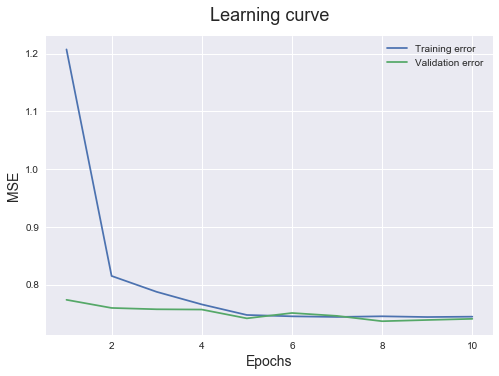

In [22]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(range(1, EPOCHS+1), train_losses, label = 'Training error')
plt.plot(range(1, EPOCHS+1), val_losses, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.title('Learning curve', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [23]:
test_ds = TabularDataset(data=test, cat_cols=categorical_features)
test_dl = DataLoader(test_ds, batch_size=batchsize, shuffle=False)

In [24]:
preds = []
with torch.no_grad():
    for _, cont_x, cat_x in test_dl:
        cat_x = cat_x.to(device)
        cont_x = cont_x.to(device)
        outputs = model(cont_x, cat_x).numpy()
        preds.append(outputs)

        
flat_preds = [item[0] for sublist in preds for item in sublist]

In [25]:
sub['target']=flat_preds
sub.to_csv('submission.csv', index=False)